In [47]:
#%% 導入需要的套件
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.preprocessing import label_binarize
import joblib
import seaborn as sns
from sklearn.svm import SVC
from gensim.models import Word2Vec
import nltk
import string
import json
import pickle
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack
from collections import Counter
from joblib import Parallel, delayed
from joblib import dump
from joblib import load
from sklearn.pipeline import make_pipeline

In [48]:
# 導入數據集隨機抽取５萬筆資料
file_path = 'Suicide_Detection.csv'
df = pd.read_csv(file_path)
#df = df.sample(n=50000, random_state=42)

print(df.head())
df['class'].value_counts()

   Unnamed: 0                                               text        class
0           2  Ex Wife Threatening SuicideRecently I left my ...      suicide
1           3  Am I weird I don't get affected by compliments...  non-suicide
2           4  Finally 2020 is almost over... So I can never ...  non-suicide
3           8          i need helpjust help me im crying so hard      suicide
4           9  I’m so lostHello, my name is Adam (16) and I’v...      suicide


class
suicide        116037
non-suicide    116037
Name: count, dtype: int64

In [49]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()

# Extend stop words list
custom_stop_words = list(ENGLISH_STOP_WORDS.union(set(stopwords.words('english'))))
additional_stop_words = ['want', 'feel', 'year', 'like', 'know', 'time', 'really', 'think', 'going', 'thing', 'day', 'make']
custom_stop_words.extend(additional_stop_words)

# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in custom_stop_words])
    return text

# Function to get sentiment scores
def get_sentiment(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']  # Compound score

In [50]:
# 清除不必要的字及計算分數
df['cleaned_text'] = df['text'].apply(clean_text)
df['sentiment_score'] = df['cleaned_text'].apply(get_sentiment)

print(df['sentiment_score'].head())


0   -0.9666
1    0.5719
2   -0.6469
3   -0.2023
4   -0.9967
Name: sentiment_score, dtype: float64


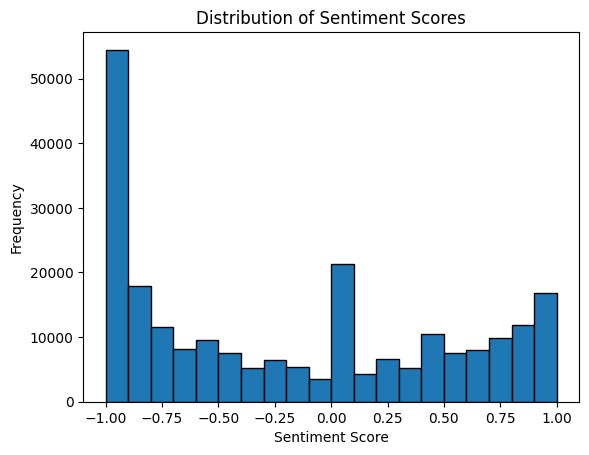

In [51]:
#畫分數長條圖
plt.hist(df['sentiment_score'], bins=20, edgecolor='k')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()
#threshold = 0.9
#cf = df[df['sentiment_score'] >= threshold]

In [52]:
# Define function to classify suicide risk
def classify_risk(score):
    if score >= 0.5:
        return 'Very Low Risk'
    elif score >= 0:
        return 'Low Risk'
    elif score >= -0.5:
        return 'Moderate Risk'
    else:
        return 'High Risk'

# Apply the function to create a new column 'risk_level'
df['risk_level'] = df['sentiment_score'].apply(classify_risk)

# Display the first few rows to check
print(df[['class', 'sentiment_score', 'risk_level']].head(20))


          class  sentiment_score     risk_level
0       suicide          -0.9666      High Risk
1   non-suicide           0.5719  Very Low Risk
2   non-suicide          -0.6469      High Risk
3       suicide          -0.2023  Moderate Risk
4       suicide          -0.9967      High Risk
5       suicide          -0.8765      High Risk
6       suicide          -0.9371      High Risk
7       suicide           0.0000       Low Risk
8   non-suicide           0.8498  Very Low Risk
9       suicide          -0.9612      High Risk
10      suicide          -0.3400  Moderate Risk
11      suicide          -0.8545      High Risk
12      suicide          -0.9100      High Risk
13      suicide           0.8583  Very Low Risk
14      suicide          -0.3818  Moderate Risk
15  non-suicide          -0.6808      High Risk
16      suicide          -0.9623      High Risk
17  non-suicide          -0.4939  Moderate Risk
18  non-suicide          -0.6597      High Risk
19      suicide          -0.6124      Hi

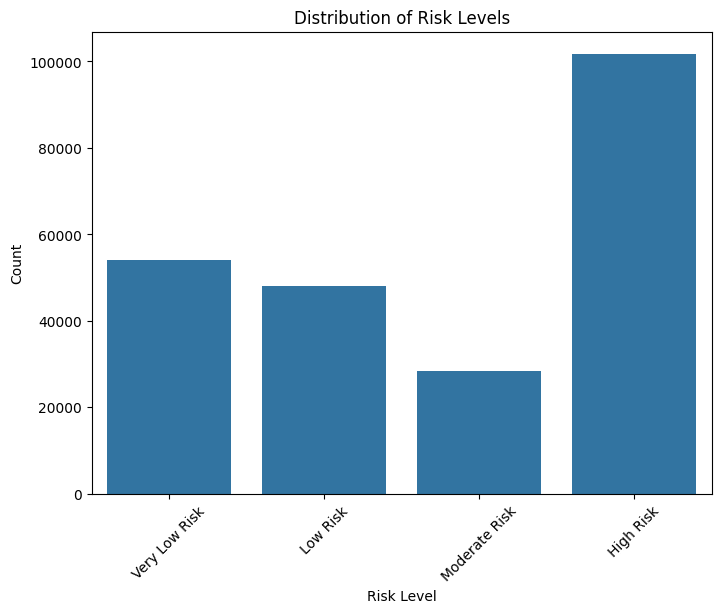

In [53]:
# Bar Plot of Risk Levels
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='risk_level', order=['Very Low Risk', 'Low Risk', 'Moderate Risk', 'High Risk'])
plt.title('Distribution of Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [54]:
# Display the first few rows to check
def count_sentiment_words(text):
    words = text.split()
    positive_count = 0
    negative_count = 0
    
    for word in words:
        score = sia.polarity_scores(word)
        if score['compound'] > 0:  # 正面情绪
            positive_count += 1
        elif score['compound'] < 0:  # 負面情緒
            negative_count += 1
    
    return pd.Series([positive_count, negative_count], index=['positive_count', 'negative_count'])

# 對 DataFrame 應用函數
df[['positive_count', 'negative_count']] = df['cleaned_text'].apply(count_sentiment_words)

# 输出结果
print(df[['class','positive_count','negative_count' ]].head(20))

          class  positive_count  negative_count
0       suicide               6              12
1   non-suicide               2               2
2   non-suicide               1               3
3       suicide               1               2
4       suicide              13              41
5       suicide              16              18
6       suicide               9              10
7       suicide               0               0
8   non-suicide              10               7
9       suicide               6              11
10      suicide               0               1
11      suicide               5               8
12      suicide               1               5
13      suicide               8               4
14      suicide               1               1
15  non-suicide               1               2
16      suicide               7              11
17  non-suicide               0               1
18  non-suicide               0               1
19      suicide               6         

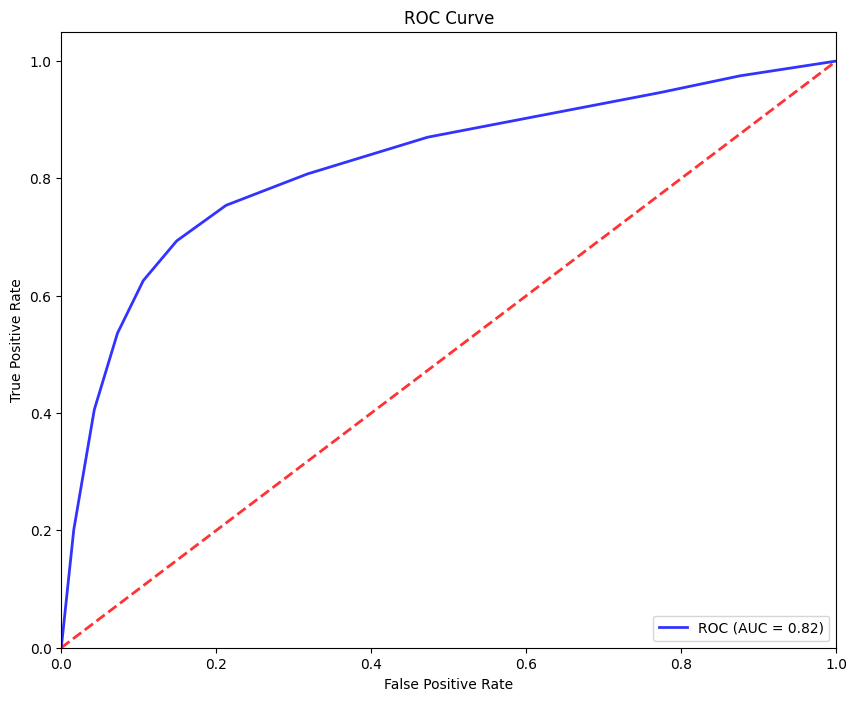

              precision    recall  f1-score   support

 non-suicide       0.74      0.85      0.79     34824
     suicide       0.82      0.69      0.75     34799

    accuracy                           0.77     69623
   macro avg       0.78      0.77      0.77     69623
weighted avg       0.78      0.77      0.77     69623



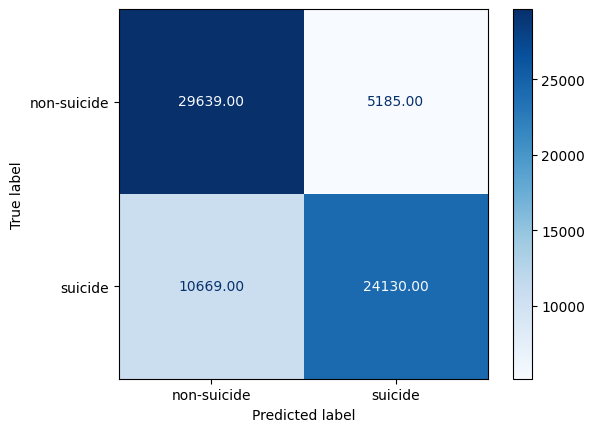

In [55]:
#進行編碼
le_class = LabelEncoder().fit(df['class'])
df_label = le_class.transform(df['class'])
df_label.shape

# Prepare features and labels
X = df[['sentiment_score', 'positive_count', 'negative_count']].values
y = df_label

# Standardize the feature set
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 分訓練集及測試集
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.3,random_state=42)
# 讀取已儲存的模型
knn_model = joblib.load('knn_model.joblib')

# 進行預測（以下是基於測試集進行預測的示例）
y_pred = knn_model.predict(X_test)
y_pred_prob = knn_model.predict_proba(X_test)[:, 1]

# 計算 ROC 曲線和 AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)

# 繪製 ROC 曲線
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='b', label=f'ROC (AUC = {roc_auc:.2f})', lw=2, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# 繪製混淆矩陣
cm = confusion_matrix(y_test, y_pred, labels=le_class.transform(le_class.classes_))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_class.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='.2f')

# 輸出分類報告
report = classification_report(y_test, y_pred, target_names=le_class.classes_)
print(report)


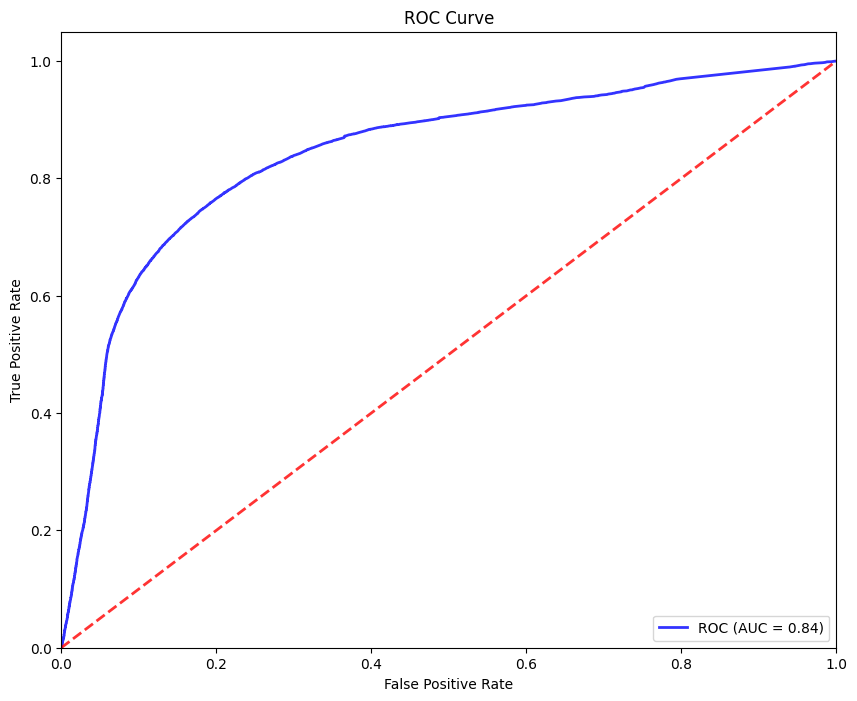

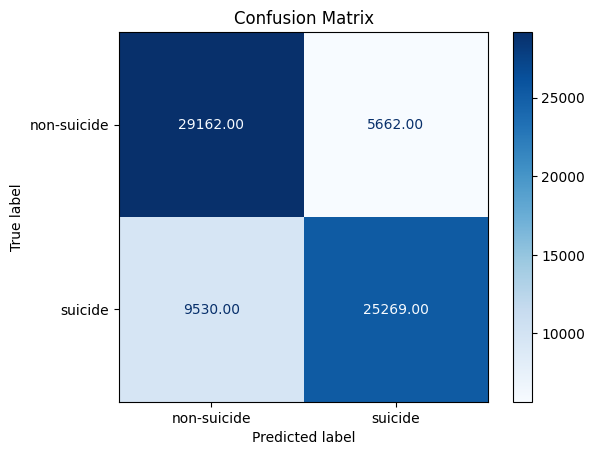

              precision    recall  f1-score   support

 non-suicide       0.75      0.84      0.79     34824
     suicide       0.82      0.73      0.77     34799

    accuracy                           0.78     69623
   macro avg       0.79      0.78      0.78     69623
weighted avg       0.79      0.78      0.78     69623



In [56]:
# 讀取已儲存的模型
svm_model = joblib.load('svm_model999.joblib')

# 使用讀取的模型進行預測（以下是基於測試集進行預測的示例）
y_pred1 = svm_model.predict(X_test)
y_pred_prob1 = svm_model.predict_proba(X_test)[:, 1]

# 計算 ROC 曲線和 AUC
fpr1, tpr1, _ = roc_curve(y_test, y_pred_prob1, pos_label=1)
roc_auc1 = auc(fpr1, tpr1)

# 繪製 ROC 曲線
plt.figure(figsize=(10, 8))
plt.plot(fpr1, tpr1, color='b', label=f'ROC (AUC = {roc_auc1:.2f})', lw=2, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# 繪製混淆矩陣
cm = confusion_matrix(y_test, y_pred1, labels=le_class.transform(le_class.classes_))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_class.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='.2f')
plt.title('Confusion Matrix')
plt.show()

# 輸出分類報告
report = classification_report(y_test, y_pred1, target_names=le_class.classes_)
print(report)


In [57]:
sentences = df['text']

# 分词
tokenized_sentences = sentences.apply(simple_preprocess)

# 加载 Word2Vec 模型和 TF-IDF 字典
model = joblib.load('word2vec_model.pkl')
tfidf_dict = joblib.load('tfidf_dict.pkl')

# 函数：将句子转化为TF-IDF加权平均的向量
def sentence_to_vector(sentence, model, tfidf_dict):
    vectors = []
    weights = []
    for word in sentence:
        if word in model.wv:
            vectors.append(model.wv[word])
            weights.append(tfidf_dict.get(word, 1.0))
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.average(vectors, axis=0, weights=weights)

# 将 Series 中的每个句子转换为向量
sentence_vectors = np.array([sentence_to_vector(sentence, model, tfidf_dict) for sentence in tokenized_sentences])

In [58]:
X_train, X_test, y_train, y_test = train_test_split(sentence_vectors,y,test_size=0.3,random_state=42)

# 加载已保存的 KNN 和 SVM 模型
best_knn = joblib.load('best_knn_model.pkl')
best_svm = joblib.load('best_svm_model.pkl')

# 混淆矩阵和分类报告函数
def evaluate_model(model, X_test, y_test, label_encoder, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n{model_name} - Confusion Matrix:")
    print(cm)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.show()
    
    print(f"\n{model_name} - Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

In [59]:
# ROC 曲線繪製函數
def plot_roc_curve(model, X_test, y_test, model_name):
    if isinstance(model, KNeighborsClassifier):
        y_score = model.predict_proba(X_test)
        y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
        n_classes = y_test_binarized.shape[1]

        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(10, 7))
        colors = ['blue', 'red', 'green']
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
    else:
        y_score = model.decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(10, 6))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name} Classifier')
    plt.legend(loc='lower right')
    plt.show()


KNN - Confusion Matrix:
[[25977  8847]
 [ 1162 33637]]


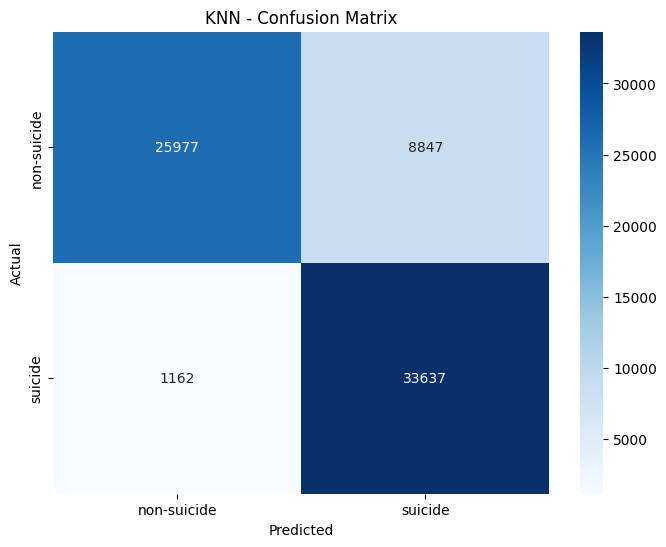


KNN - Classification Report:
              precision    recall  f1-score   support

 non-suicide       0.96      0.75      0.84     34824
     suicide       0.79      0.97      0.87     34799

    accuracy                           0.86     69623
   macro avg       0.87      0.86      0.85     69623
weighted avg       0.87      0.86      0.85     69623


SVM - Confusion Matrix:
[[32112  2712]
 [ 2018 32781]]


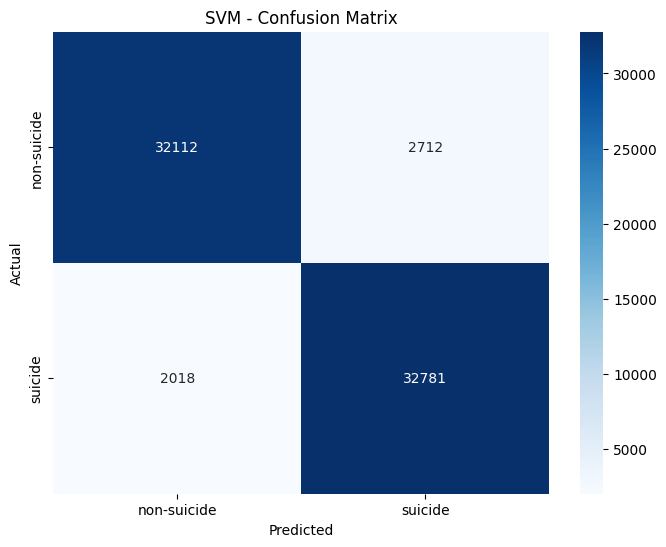


SVM - Classification Report:
              precision    recall  f1-score   support

 non-suicide       0.94      0.92      0.93     34824
     suicide       0.92      0.94      0.93     34799

    accuracy                           0.93     69623
   macro avg       0.93      0.93      0.93     69623
weighted avg       0.93      0.93      0.93     69623



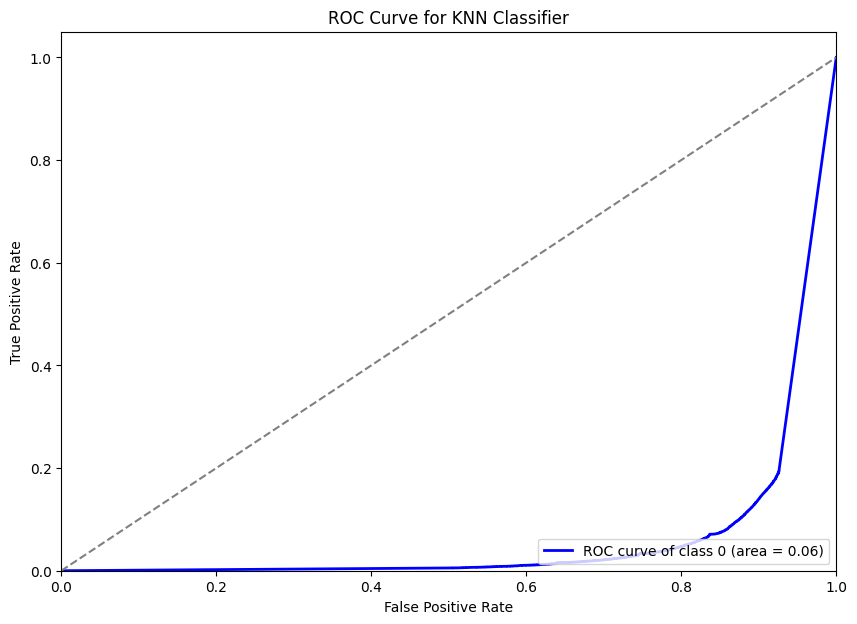

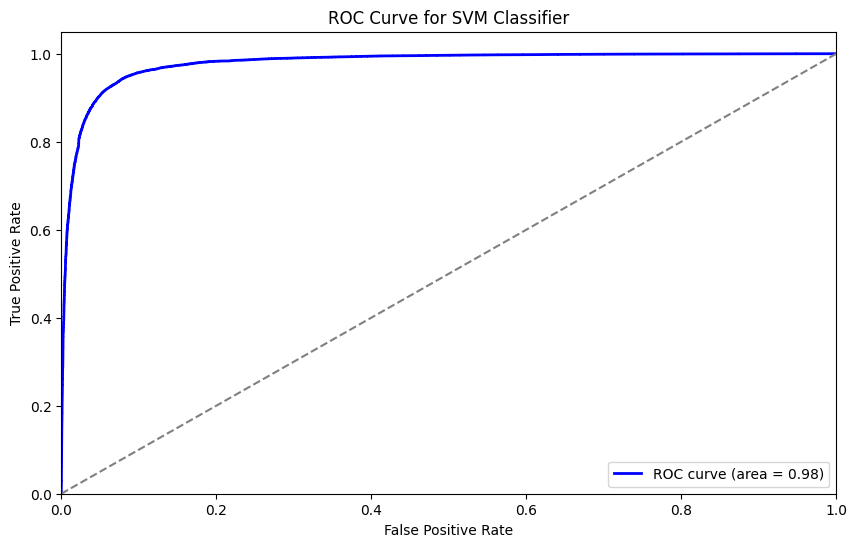

In [60]:
# 评估 KNN 和 SVM 模型
evaluate_model(best_knn, X_test, y_test, le_class, "KNN")
evaluate_model(best_svm, X_test, y_test, le_class, "SVM")

# 绘制 KNN 和 SVM 模型的 ROC 曲线
plot_roc_curve(best_knn, X_test, y_test, "KNN")
plot_roc_curve(best_svm, X_test, y_test, "SVM")

In [61]:
# Compute TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=100, ngram_range=(1, 2), stop_words=custom_stop_words)
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])

# Get top words based on TF-IDF
tfidf_scores = zip(tfidf_vectorizer.get_feature_names_out(), X_tfidf.sum(axis=0).tolist()[0])
tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
top_20_words = [word for word, score in tfidf_scores[:100]]

In [62]:
# Prepare texts for Word2Vec
texts_for_w2v = [simple_preprocess(text) for text in df['cleaned_text']]
word2vec_model = Word2Vec(sentences=texts_for_w2v, vector_size=100, window=5, min_count=1, workers=4)

# Display word similarities
print("Semantic similarities:")
for word in top_20_words[:20]:
    similar_words = word2vec_model.wv.most_similar(word, topn=5)
    print(f"\nSimilar words to '{word}':")
    for similar_word, similarity in similar_words:
        print(f"{similar_word}: {similarity:.2f}")

Semantic similarities:

Similar words to 'life':
world: 0.65
miserable: 0.64
truly: 0.61
anymore: 0.60
future: 0.59

Similar words to 'people':
person: 0.73
mean: 0.64
actually: 0.63
genuinely: 0.62
anybody: 0.60

Similar words to 'friend':
acquaintance: 0.72
girlfriend: 0.66
boyfriend: 0.65
friendship: 0.63
talk: 0.61

Similar words to 'help':
advice: 0.71
helping: 0.70
professional: 0.66
support: 0.62
talk: 0.61

Similar words to 'need':
needing: 0.67
willing: 0.63
needed: 0.61
help: 0.59
somebody: 0.59

Similar words to 'im':
dont: 0.72
thats: 0.69
isnt: 0.68
theyre: 0.66
there: 0.64

Similar words to 'got':
getting: 0.70
gotten: 0.68
went: 0.67
gave: 0.60
turned: 0.58

Similar words to 'good':
great: 0.78
bad: 0.77
decent: 0.69
terrible: 0.66
nice: 0.61

Similar words to 'fucking':
goddamn: 0.81
fuck: 0.74
hate: 0.70
stupid: 0.68
literally: 0.66

Similar words to 'say':
tell: 0.76
saying: 0.72
mean: 0.69
said: 0.68
understand: 0.63

Similar words to 'thought':
thinking: 0.68
ideati

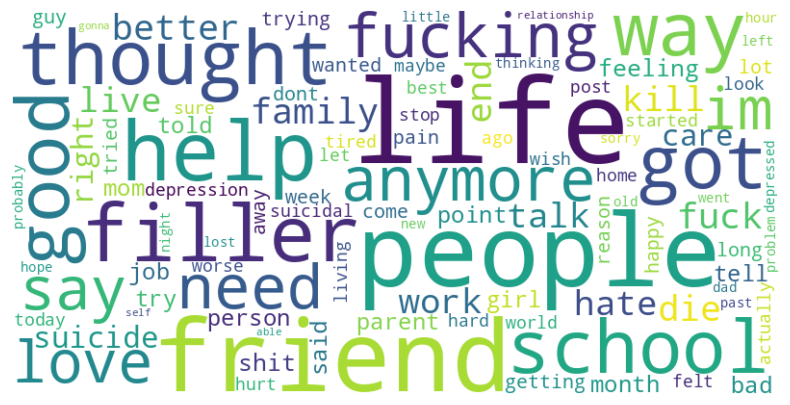

In [63]:
# Compute word counts
count_vectorizer = CountVectorizer(vocabulary=top_20_words)
X_count = count_vectorizer.fit_transform(df['cleaned_text'])
freq_counts = zip(count_vectorizer.get_feature_names_out(), X_count.sum(axis=0).tolist()[0])
freq_counts = sorted(freq_counts, key=lambda x: x[1], reverse=True)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(freq_counts))

# Display word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [64]:
#%% 替換 suicide & non-suicide 的標籤= <label>
df['label'] = df['class'].map({'suicide': 1, 'non-suicide': 0})

#%% 定義變數意義
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

#%% 清理文本函数
def clean_and_filter_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]|http\S+|[^a-zA-Z\s]', ' ', text)
    words = word_tokenize(text)
    return ' '.join([word for word in words if word not in stop_words and word not in punctuation])

#%% 並行化文本清理，用以加快處理大量文本數據的速度
df['cleaned_text'] = Parallel(n_jobs=8)(delayed(clean_and_filter_text)(text) for text in df['text'])

In [65]:
####特徵工程part####

#%% 提取形容詞和副詞
def extract_adjectives_and_adverbs(text):
    words = word_tokenize(text)
    tagged_words = pos_tag(words)
    return [word for word, tag in tagged_words if tag in ('JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS')]

df['adjectives_adverbs'] = Parallel(n_jobs=8)(delayed(extract_adjectives_and_adverbs)(text) for text in df['cleaned_text'])

#%% 提取 token use tri-grams
def get_ngrams(text, n):
    return [' '.join(gram) for gram in nltk.ngrams(word_tokenize(text), n)]

df['tri_grams'] = Parallel(n_jobs=8)(delayed(get_ngrams)(text, 3) for text in df['cleaned_text'])

#%% 導入NRC情感词典
def load_nrc_lexicon(path):
    nrc_lexicon = pd.read_csv(path, sep='\t', header=None, names=['word', 'emotion', 'association'])
    nrc_lexicon = nrc_lexicon[nrc_lexicon['association'] == 1]
    emotion_dict = {}
    for _, row in nrc_lexicon.iterrows():
        word = row['word']
        emotion = row['emotion']
        if emotion not in emotion_dict:
            emotion_dict[emotion] = set()
        emotion_dict[emotion].add(word)
    return emotion_dict

nrc_lexicon_path = "NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
emotion_dict = load_nrc_lexicon(nrc_lexicon_path)

#%% 計算 NRC 情感得分
def get_nrc_emotion_scores(text):
    words = word_tokenize(text.lower())
    emotion_scores = Counter()
    for word in words:
        for emotion, words_set in emotion_dict.items():
            if word in words_set:
                emotion_scores[emotion] += 1
    return emotion_scores

df['emotion_scores'] = Parallel(n_jobs=8)(delayed(get_nrc_emotion_scores)(text) for text in df['cleaned_text'])
#%% 轉成特徵矩陣
vectorizer = CountVectorizer(max_features=10000, min_df=5, max_df=0.9)
X_text_features = vectorizer.fit_transform(df['cleaned_text'])

# %% 計算情緒分數 >跑很久
sia = SentimentIntensityAnalyzer()
df[['pos', 'neu', 'neg', 'compound']] = Parallel(n_jobs=8)(delayed(lambda x: pd.Series(sia.polarity_scores(x)))(text) for text in df['cleaned_text'])

#%% 合併情緒分數和文字特徵
#使用VADER跟NRC跟tri-gram的形容詞與副詞當作特徵篩選
sentiment_scores = df[['pos', 'neu', 'neg', 'compound']].values

X = hstack((X_text_features, sentiment_scores))  
y = df['label'] 

Cross-validation scores: [0.92766347 0.92567058 0.92938705 0.92954864 0.92825595 0.92890229
 0.92841754 0.92809437 0.92518582 0.93072987]
Mean CV score: 0.9281855581701389


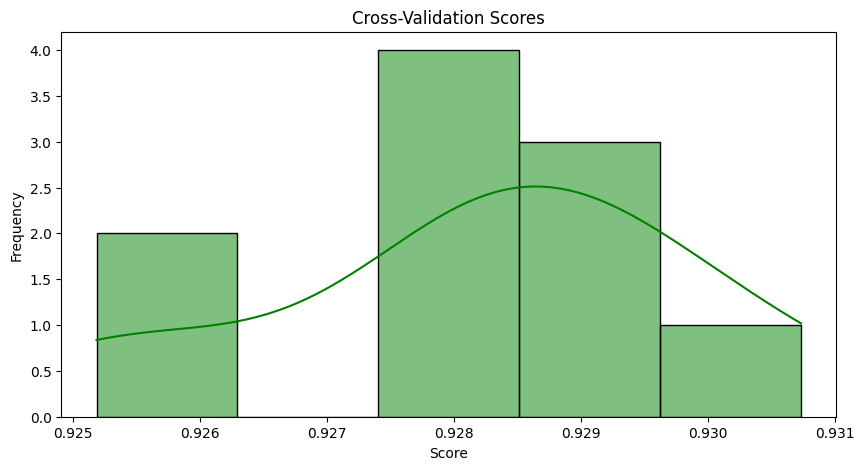

Accuracy: 92.04%
Classification Report:
              precision    recall  f1-score   support

 Non-Suicide       0.91      0.94      0.92      5009
     Suicide       0.93      0.90      0.92      4991

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [66]:
#### 進入模型階段 ####

#%% 分層分割(保持類別比例)和交叉驗證
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#%% Logistic Regression with parallel processing
model = LogisticRegression(n_jobs=8)
cross_val_scores = cross_val_score(model, X_train, y_train, cv=10, n_jobs=8)
print(f'Cross-validation scores: {cross_val_scores}')  # 各層分數
print(f'Mean CV score: {cross_val_scores.mean()}')  # 總平均

#可視化交叉驗證结果
plt.figure(figsize=(10, 5))
sns.histplot(cross_val_scores, kde=True, color='green')
plt.title('Cross-Validation Scores')  
# Combined title
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

#Logistic Regression 模型訓練+測試
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#%% 保存跟加载 Logistic Regression 模型
#dump(model, 'logistic_regression_model.joblib')
model = load('logistic_regression_model.joblib')
model

#%% 導出結果指標
with open('model_metrics.json', 'r') as f:
    metrics = json.load(f)

print(f"Accuracy: {metrics['accuracy'] * 100:.2f}%")
print("Classification Report:")
print(metrics['classification_report'])

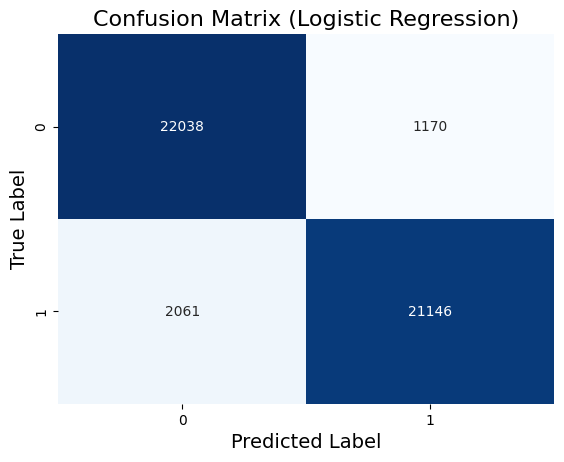

AUC Score (Logistic Regression): 0.54


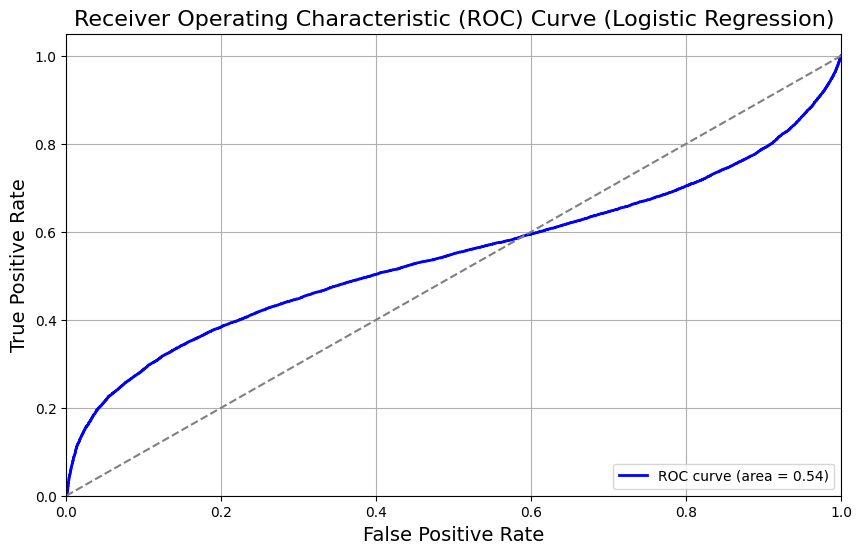

Probability of suicide detection (Logistic Regression): 15.54%
Accuracy: 89.13%
Classification Report:
              precision    recall  f1-score   support

 Non-Suicide       0.89      0.89      0.89      5009
     Suicide       0.89      0.89      0.89      4991

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [67]:
#%% 邏輯斯回歸混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix (Logistic Regression)", fontsize=16)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.show()

#%% 計算和繪製 roc 曲線
from sklearn.metrics import roc_curve, roc_auc_score

#%% Logistic Regression ROC curve and AUC score
y_pred_prob_log = model.predict_proba(X_test)[:, 1]
fpr_log, tpr_log, thresholds_log = roc_curve(y_test, y_pred_prob_log)
auc_score_log = roc_auc_score(y_test, y_pred_prob_log)
print(f"AUC Score (Logistic Regression): {auc_score_log:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(fpr_log, tpr_log, color='blue', lw=2, label=f'ROC curve (area = {auc_score_log:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve (Logistic Regression)', fontsize=16)
plt.legend(loc='lower right')
plt.grid()
plt.show()

#%% 定義Logistic Regression的預測函數
def predict_suicide_probability_logreg(text):
    cleaned_text = clean_and_filter_text(text)
    text_features = vectorizer.transform([cleaned_text])
    sentiment_scores = np.array([list(sia.polarity_scores(cleaned_text).values())])
    combined_features = hstack([text_features, sentiment_scores])
    prob = model.predict_proba(combined_features)[0, 1] * 100
    return prob

#%% 测试Logistic Regression-new data
test_text = "Every day feels like a struggle to find meaning in a world that seems indifferent to my suffering, as if the light has permanently faded from my life and hope has become a distant memory."
probability = predict_suicide_probability_logreg(test_text)
print(f"Probability of suicide detection (Logistic Regression): {probability:.2f}%")

with open('svm_model.json', 'r') as f:
    metrics = json.load(f)

print(f"Accuracy: {metrics['accuracy'] * 100:.2f}%")
print("Classification Report:")
print(metrics['classification_report'])


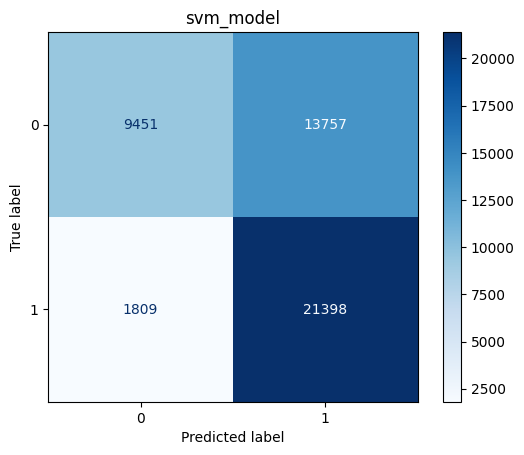

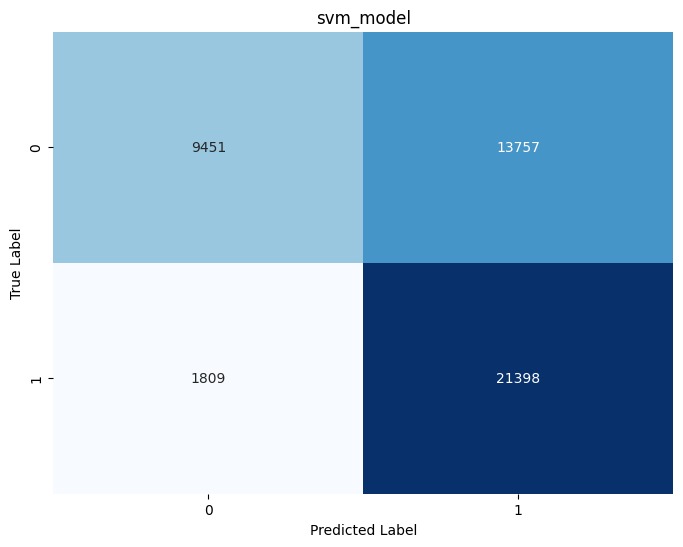

In [68]:
#%%保存模型"已經訓練好的"svm_model模型
#dump(svm_model,'svm_model.joblib')
svm_model = load('svm_model.joblib')
svm_model

#%%
# 使用模型進行預測
y_pred_svm = svm_model.predict(X_test)
#%%
# 計算混淆矩陣
cm = confusion_matrix(y_test, y_pred_svm)

# svm混淆矩陣顯示混淆矩陣
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("svm_model")
plt.show()

# 視覺化和美化
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("svm_model")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
#%%


AUC Score (SVM): 0.77


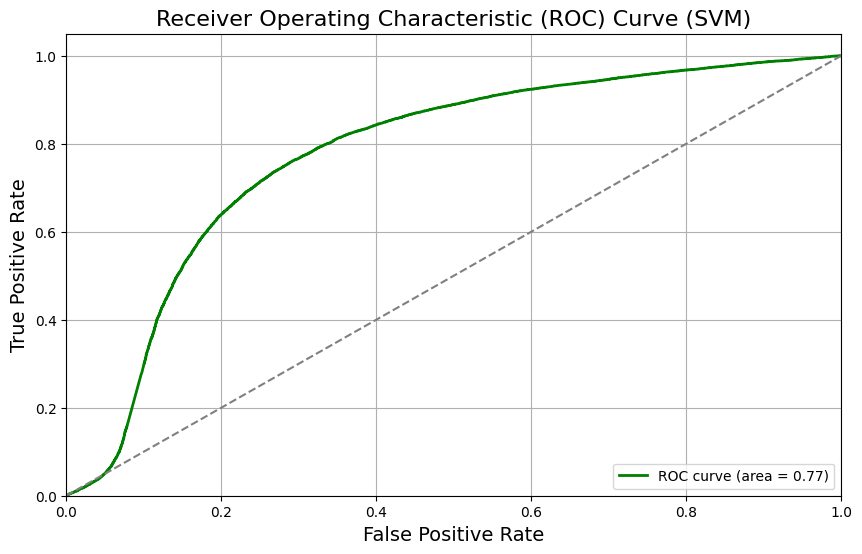

In [69]:
#%% SVM ROC curve and AUC score
y_pred_prob_svm = svm_model.predict_proba(X_test)[:, 1]
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_pred_prob_svm)
auc_score_svm = roc_auc_score(y_test, y_pred_prob_svm)
print(f"AUC Score (SVM): {auc_score_svm:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(fpr_svm, tpr_svm, color='green', lw=2, label=f'ROC curve (area = {auc_score_svm:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve (SVM)', fontsize=16)
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [70]:
####新數據測試+定義####

#%% SVM的預測函数
def predict_suicide_probability_svm(text):
    # 清理和過濾文本
    cleaned_text = clean_and_filter_text(text)
    
    # 提取文本特徵
    text_features = vectorizer.transform([cleaned_text])
    
    # 獲取情感分數，特別是負面情感分數
    sentiment_scores = sia.polarity_scores(cleaned_text)
    negative_sentiment = sentiment_scores['neg']
    
    # 確保負面情感分數是有效的
    if negative_sentiment is None:
        negative_sentiment = 0.0  # 如果不存在，設為0
    
    # 將情感分數轉換為數值向量
    sentiment_vector = np.array([sentiment_scores['pos'], sentiment_scores['neu'], negative_sentiment, sentiment_scores['compound']])
    
    # 合併文本特徵與情感特徵
    combined_features = hstack([text_features, sentiment_vector])
    
    # 使用SVM模型進行預測
    prob = svm_model.predict_proba(combined_features)[0, 1] * 100
    
    return prob

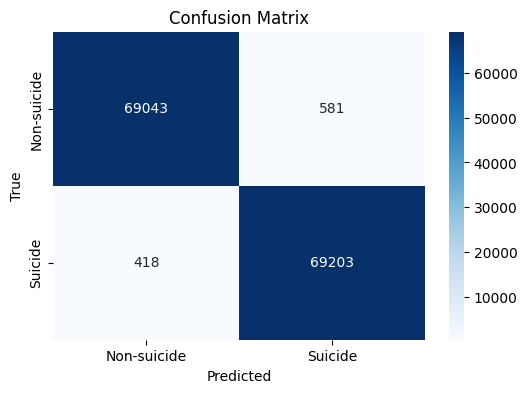

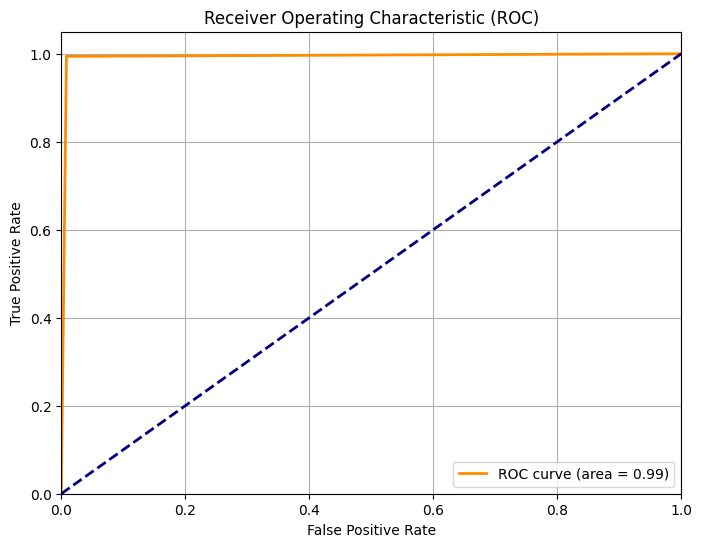

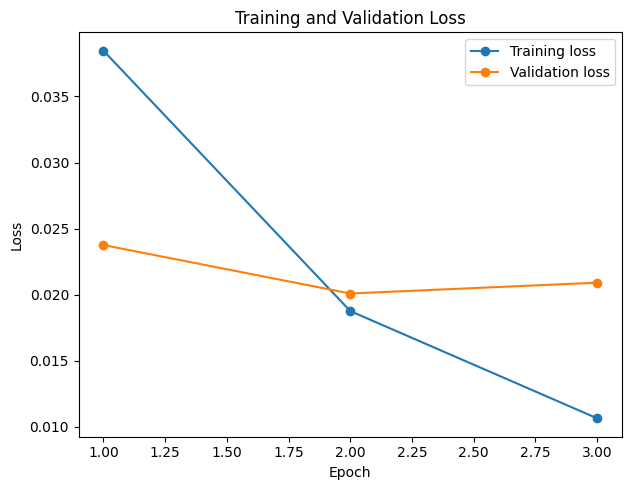

In [71]:
#%% 可视化混淆矩阵
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

#%% ROC曲线和AUC
def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

#%% 学习曲线
def plot_learning_curve(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'o-', label='Training loss')
    plt.plot(epochs, val_losses, 'o-', label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

#%% 使用保存的結果進行可視化
if __name__ == "__main__":
    # 读取保存的结果
    data = np.load('roberta_results.npz')
    
    train_labels = data['train_labels']
    train_preds = data['train_preds']
    val_labels = data['val_labels']
    val_preds = data['val_preds']
    train_losses = data['train_losses']
    val_losses = data['val_losses']

    # 可視化混淆矩陣
    plot_confusion_matrix(val_labels, val_preds, class_names=['Non-suicide', 'Suicide'])

    # 可視化ROC曲線
    plot_roc_curve(val_labels, val_preds)

    # 可視化學習曲線
    plot_learning_curve(train_losses, val_losses)